
# Vector Representations
## *Data Science Unit 4 Sprint 1 Assignment 2*

## 0.1 Get `spacy`

##0.2 Restart Runtime

## 0.3 Imports

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

%matplotlib inline

import spacy
nlp = spacy.load("en_core_web_md")

##0.4 Clone the git repo
so we can access the files in the `/data` folder

In [ ]:
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git


Cloning into 'DS-Unit-4-Sprint-1-NLP'...
remote: Enumerating objects: 1620, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 1620 (delta 42), reused 36 (delta 12), pack-reused 1531
Receiving objects: 100% (1620/1620), 58.45 MiB | 20.88 MiB/s, done.
Resolving deltas: 100% (211/211), done.


## 1) Clean the Job Listings from indeed.com that contain the title "Data Scientist" 

The file `job_listings.csv` is in the `data` folder for this module. <br>
Navigate to the `data` folder in the `DS-Unit-4-Sprint-1-NLP` folder icon in the left sidebar. 
Find the path to `job_listings.csv` (all the way at the bottom of the list of files in `data`), by clicking on the "three dots" symbol to the right of its file icon.

In [2]:
data_path = "./data/job_listings.csv"
df = pd.read_csv(data_path)

In [3]:
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


### Remove `HTML tags`

The text data in the description column is messy - it's full of html tags! <br>
Use the [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column by removing html tags. <br>
* You will need to read through the `BeautifulSoup` documentation to accomplish this task. <br>
* As with any library, there is lots of documentation, but read only what you need! 
* Don't spend more time than it takes to figure out how to remove html tags! 


In [66]:
def remove_html(text):
    """
    Extract text from html boiler plate code. 
    Converts bytes dtype into str dtype
    
    Note
    ----
    Use the regex editor to help you create regular expressions https://regex101.com/
    
    Parameters
    ----------
    text: string or object 
        contains text data that we want to clean
    
    Returns 
    -------
    text: str 
        cleaned text data ready for vectorization
    """
    
    # create soup object 
    soup = BeautifulSoup(text, "html.parser")
    
    # extract text from page using beautiful soup
    # eval will strip off whatever datatype or expression that's inside of a string 
    #    see https://docs.python.org/3/library/functions.html#eval for eval docs
    text =  soup.get_text()
    
    # if text is a byte data type, then convert to string 
    if isinstance(text, bytes):
        
        # convert byte data type into str
        text =  text.decode("utf-8")
        
    
    # use regex to clean your text data
    ###BEGIN SOLUTION
    text = re.sub("^b", " ", text) #leading b's
    text = re.sub(r"(?:\\n)", " ", text) #newlines to spaces
    text =re.sub(r"(?:\\x.{2})", " ", text) #extraneous escape seq.
    text = re.sub("[^0-9a-zA-Z\s]", "", text)

    ###END SOLUTION
    
    # case normalize and strip extra white spaces on the far left and right hand side
    text = text.lower().strip()


    return text

In [67]:
df["clean_text"] = df.description.apply(lambda text: remove_html(text))
# would this work? df["clean_text"] = df.description.apply(remove_html)

In [68]:
df.clean_text

0      job requirements conceptual understanding in m...
1      job description  as a data scientist 1 you wil...
2      as a data scientist you will be working on con...
3      4969  6756 a monthcontractunder the general su...
4      location usa     multiple locations 2 years of...
                             ...                        
421    about us want to be part of a fantastic and fu...
422    internshipat uber we ignite opportunity by set...
423    200000  350000 a yeara million people a year d...
424    senior data scientist job description  about u...
425    cerner intelligence is a new innovative organi...
Name: clean_text, Length: 426, dtype: object

## 2) Use Spacy to tokenize the listings 
Remove stop words, punctuation and spaces, and whatever else you want to remove

In [69]:
## YOUR CODE HERE
def tokenizer(text):
    """
    Uses spaCy language model to tokenize text. 
    Token filters are used to exclude low quality tokens.
    
    Note
    ----
    Remember to check out the spacy docs to see which token flags are available for you to use
    https://spacy.io/api/token
    
    Input
    ----------
    text: string
        raw text document that needs to be tokenized
        
    Returns
    -------
    tokens: list of strings
    """
    
    tdoc = nlp(text)
    return [t.lemma_ for t in tdoc if (~t.is_stop & ~t.is_punct & (len(t.lemma_.strip()) > 1))]


### Apply our tokenizer function via `pandas.apply()`

In [70]:
df["lemmas"] = df.clean_text.apply(tokenizer)

In [71]:
df["lemmas"]

0      [job, requirement, conceptual, understanding, ...
1      [job, description, data, scientist, help, buil...
2      [data, scientist, work, consult, business, res...
3      [4969, 6756, monthcontractunder, general, supe...
4      [location, usa, multiple, location, year, anal...
                             ...                        
421    [want, fantastic, fun, startup, revolutionize,...
422    [internshipat, uber, ignite, opportunity, set,...
423    [200000, 350000, yeara, million, people, year,...
424    [senior, data, scientist, job, description, am...
425    [cerner, intelligence, new, innovative, organi...
Name: lemmas, Length: 426, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

- Instantiate a `CountVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `CountVectorizer`
- Use `CountVectorizer` to create a *document-term matrix* 
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `CountVectorizer` object
- Consider using `CountVectorizer` parameters like `stop_words` and `max_df`, `min_df` to trim your results
    
Once you've created your `dtm` dataframe, you might notice that some (or many) of your features result from data that still needs more cleaning. Use this as an opportunity to iteratively improve your `tokenizer` function. 

In [115]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL
vect = CountVectorizer(tokenizer=tokenizer, min_df=0.05, max_df=0.95)
# Here, tf stands for "term frequency, i.e. counts for each term"
dtm_tf = vect.fit_transform(df['clean_text'])
dtm_tf = pd.DataFrame(dtm_tf.todense(), columns=vect.get_feature_names())
###END SOLUTION

In [116]:
dtm_tf

,10,100,2019,401k,ab,ability,able,academic,accelerate,accept,...,wide,will,work,workforce,workplace,world,write,written,year,york
0,0,0,0,0,0,2,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,6,0,0,1,1,1,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,1,2,0,0,0,0,...,0,1,1,0,0,0,0,0,5,1
422,0,0,1,0,0,0,0,0,0,0,...,0,2,3,0,0,3,1,0,0,0
423,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,1,0
424,0,0,0,0,0,0,2,0,2,0,...,0,0,5,0,0,1,0,0,1,0


## 4) Visualize the most common word counts in a barplot

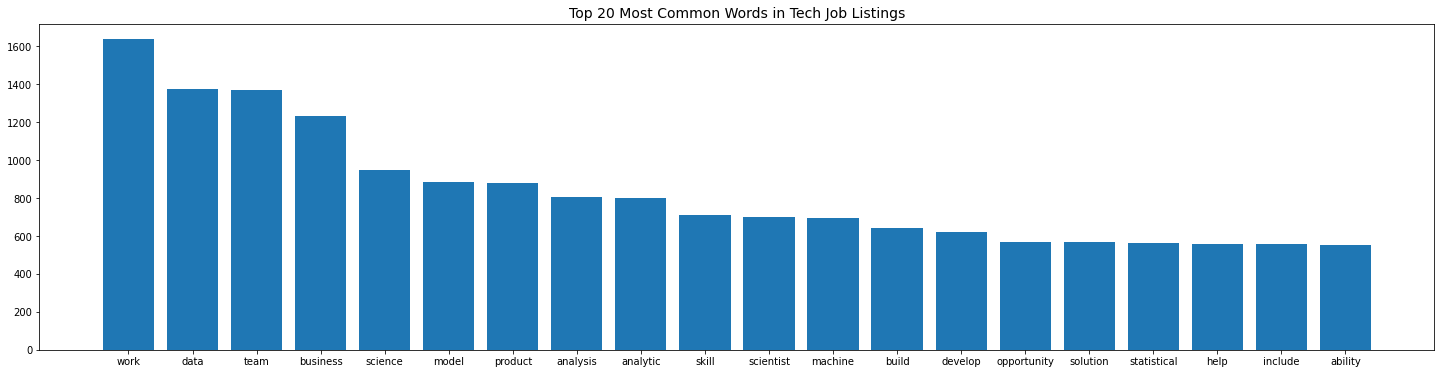

In [117]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL
top_n = 20
# sum the term counts in each column of the dtm_tf data frame and then sort in descending order
sorted_terms = [[name, sum(values)] for name, values in dtm_tf.iteritems()]
sorted_terms = sorted(sorted_terms, key=lambda col:col[1], reverse=True)

plt.figure(figsize=(25,6))
plt.title("Top {} Most Common Words in Tech Job Listings".format(top_n), fontsize=14)
plt.bar([i[0] for i in sorted_terms[:top_n]], [i[1] for i in sorted_terms[:top_n]])
plt.show()
###END SOLUTION

## 5) Use Scikit-Learn's `TfidfVectorizer` to get a TF-IDF feature matrix

- Instantiate a `TfidfVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `TfidfVectorizer`
- Use `TfidfVectorizer` to create a *document-term matrix* 
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `TfidfVectorizer` object


In [118]:
###BEGIN SOLUTION
tvect = TfidfVectorizer(tokenizer=tokenizer, min_df=0.05, max_df=0.95)
tvect.fit(df['clean_text'])
dtm_tfidf = tvect.transform(df['clean_text'])
dtm_tfidf = pd.DataFrame(dtm_tfidf.todense(), columns=tvect.get_feature_names())
###END SOLUTION

c:\Users\Jeff\anaconda3\envs\u4-s1-nlp\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [119]:
dtm_tfidf 

,10,100,2019,401k,ab,ability,able,academic,accelerate,accept,...,wide,will,work,workforce,workplace,world,write,written,year,york
0,0.0,0.0,0.000000,0.000000,0.000000,0.167720,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.061467,0.0,0.00000,0.000000,0.120939,0.000000,0.000000,0.000000
1,0.0,0.0,0.000000,0.000000,0.000000,0.030189,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.132767,0.0,0.00000,0.036825,0.043537,0.062319,0.025972,0.000000
2,0.0,0.0,0.000000,0.000000,0.000000,0.081042,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.059402,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.068369,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.123310,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,0.0,0.000000,0.000000,0.051199,0.046998,0.000000,0.0,0.000000,0.0,...,0.0,0.036630,0.017224,0.0,0.00000,0.000000,0.000000,0.000000,0.101082,0.058597
422,0.0,0.0,0.079523,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.109604,0.077307,0.0,0.00000,0.128656,0.050701,0.000000,0.000000,0.000000
423,0.0,0.0,0.000000,0.090899,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.097266,0.057497,0.000000,0.034299,0.000000
424,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.097924,0.0,0.144955,0.0,...,0.0,0.000000,0.109675,0.0,0.00000,0.036505,0.000000,0.000000,0.025745,0.000000


Stretch: see if you can make a visualization of this TF-IDF Document-Term  matrix, as you did in Part 3 for the CountVectorizer Document-Term matrix, i.e. using a barplot.

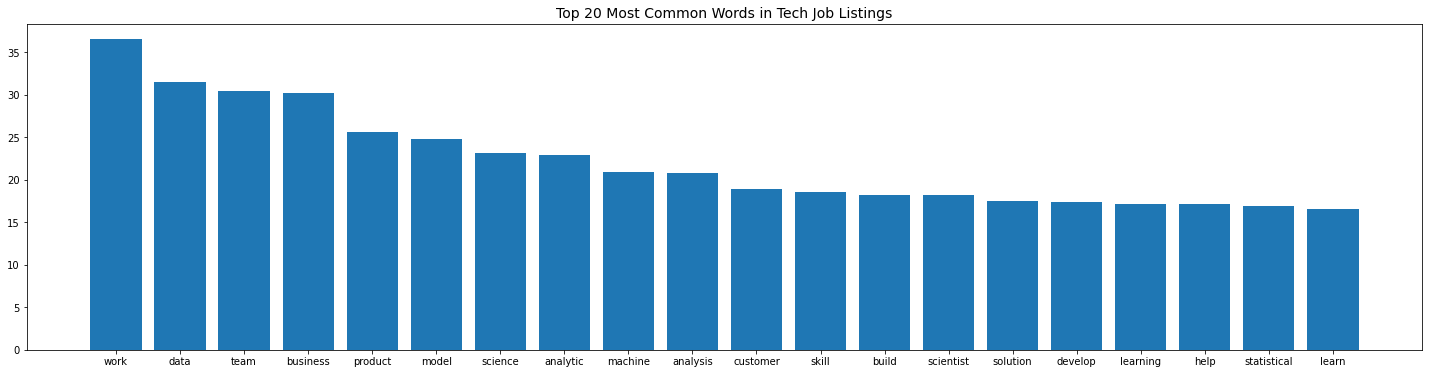

In [120]:
top_n = 20
# sum the term counts in each column of the dtm_tf data frame and then sort in descending order
sorted_terms_tfidf = [[name, sum(values)] for name, values in dtm_tfidf.iteritems()]
sorted_terms_tfidf = sorted(sorted_terms_tfidf, key=lambda col:col[1], reverse=True)

plt.figure(figsize=(25,6))
plt.title("Top {} Most Common Words in Tech Job Listings".format(top_n), fontsize=14)
plt.bar([i[0] for i in sorted_terms_tfidf[:top_n]], [i[1] for i in sorted_terms_tfidf[:top_n]])
plt.show()

## 6) Create a `NearestNeighbor` Model for the Data Science job listings
Write a some text that describes your ideal Data Science job, and query the model to identify jobs with similar descriptions!

In [121]:
ideal_ds_job_query=["more money less problems"]

In [124]:
# vectorize your ideal job description using your fitted tfidf vectorizer 
ideal_job_vector = tvect.transform(ideal_ds_job_query)

# fit NearestNeighbors model to the Indeed reviews document-term matrix that you created
nn = NearestNeighbors(n_neighbors=10, algorithm='auto')
nn.fit(tvect.transform(df['clean_text']))

# get top_n_neigh distances and review indices for reviews that are closest to your ideal job
n_dist, n_ind = nn.kneighbors(ideal_job_vector)

# look at a few of the most similar job descriptions to your ideal job
# Did your query find good matches?
print(n_ind)
print(n_dist)


[[109 252 192  77 214  96 247 358  84  89]]
[[1.21474642 1.3006191  1.3006191  1.3160925  1.3160925  1.32523455
  1.32671662 1.32844199 1.33694374 1.33936854]]


In [127]:
print(df['clean_text'][109])
#duplicates!
print(df['clean_text'][252])
print(df['clean_text'][192])
print(df['clean_text'][77])

position description the product catalog team is at the heart of walmartlabs our applications and state of the art algorithms power the content on mobile web search fulfillment pricing marketing technology and data analytics there is virtually no business function that is not affected by our work the amount of data we process is second to none we harness this data to pursue our mission of helping hundreds of millions globally to    live better and save money    minimum qualifications bachelors degree with 5 years of experience or master degree in computer sciencemachine learning established and strong data science experience in images and text processing r python tensorflow andor related technologies specific education in data science phd preferred good communication skills ability to work with diverse team additional preferred qualifications  company summary the walmart ecommerce team is rapidly innovating to evolve and define the future state of shopping as the world   s largest reta

## Stretch Goals: do one of more of these that strike your fancy!

 - Repeat Part 6, but this time using spacy's word embeddings to represent documents as vectors. Remember, to form a document vector from spacy word embeddings, you average together the word embedding vectors of all the words in the document, so the document vector will have the same dimensionality as the word embeddings, namely 300 dimensions. Do you notice any difference in the results?
 - Watch Josh Starmer's video [StatQuest: Principal Component Analysis (PCA), Step-by-Step](https://www.youtube.com/watch?v=FgakZw6K1QQ). Or read [Daniela Witten's tweetstorm](https://twitter.com/womeninstat/status/1285610321747611653?lang=en) on Singular Value Decomposition (SVD). Now go back and review the section "Can we visualize word vectors?" from the [lecture video](https://drive.google.com/file/d/1QuwkO2Uj5sONFtqCk0_d2zrks2I6stkN/view?usp=sharing). Write a brief description of your understanding of Principal Components Analysis, and how it was used to visualize word vectors. Do your own experiments to explore relationships of words in two dimensions. Write a summary of what you discovered.

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings?
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. Hint: compose a query that references a number of tech stack items. How are those items distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this; algorithms that depend on Euclidean distance break down with high dimensional data. Do a bit of research to see if you can identify a suitable clustering algorithm.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for.

In [132]:
#Part Six but with spacy
word_embed = [nlp(text).vector for text in df['clean_text'].values]
embed_vectors = np.asarray(word_embed)

In [137]:
nn = NearestNeighbors(n_neighbors=10, algorithm='auto')
nn.fit(embed_vectors)

job_embed = nlp(ideal_ds_job_query[0]).vector
job_embed = np.asarray(job_embed).reshape(1, -1)
n_dist, n_ind = nn.kneighbors(job_embed)

print(n_ind)
print(n_dist)

[[ 23 123 214  77 140 107 259  44 423 136]]
[[2.61121589 2.61121589 2.63645546 2.63645546 2.6521015  2.663463
  2.663463   2.66573813 2.66573813 2.66596717]]


In [138]:
#duplicates!
print(df['clean_text'][23])
print(df['clean_text'][123])
print(df['clean_text'][214])
print(df['clean_text'][77])

motiion is a technology and data company for the food industry we believe in transparency diversity merit and fostering a culture of accountability personal impact and career growth  as a member of the first product engineering team at motiion you have will have a unique opportunity to turning previously scattered and inconsistently structured data into directly actionable food industry insights to reduce waste increase freshness and much more  you have a proven track record of reading data and making solid conclusions you know both the art and science of analytics  now only do you know how to find answers in the data you also know which questions should be asked in the first place and what data might could help us further bolster our conclusions you love engaging with customers learn about their challenges and then dive into the data to see how to solve them  we are building a product engineering team with a breadth of combined experiences so that we can collaboratively build great pr